<a href="https://colab.research.google.com/github/grahul64/face_emotions/blob/main/face_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! rm -rf *.zip *.gz model* emo*
# ! wget -O onnx_model.zip https://github.com/onnx/models/archive/refs/heads/master.zip
! wget -O onnx_mod2.tar.gz https://github.com/onnx/models/raw/master/vision/body_analysis/emotion_ferplus/model/emotion-ferplus-8.tar.gz
# ! unzip onnx_model.zip
! tar -xzvf onnx_mod2.tar.gz

--2021-05-24 14:48:25--  https://github.com/onnx/models/raw/master/vision/body_analysis/emotion_ferplus/model/emotion-ferplus-8.tar.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/onnx/models/master/vision/body_analysis/emotion_ferplus/model/emotion-ferplus-8.tar.gz [following]
--2021-05-24 14:48:26--  https://media.githubusercontent.com/media/onnx/models/master/vision/body_analysis/emotion_ferplus/model/emotion-ferplus-8.tar.gz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32384491 (31M) [application/octet-stream]
Saving to: ‘onnx_mod2.tar.gz’

onnx_mod2.tar.gz    100%[====

In [2]:
!ls -lh
! pip install onnx
! pip install onnx_tf

total 31M
drwxrwxrwx 5 root root 4.0K Sep 24  2018 emotion_ferplus
-rw-r--r-- 1 root root  31M May 24 14:48 onnx_mod2.tar.gz
drwxr-xr-x 1 root root 4.0K May  6 13:44 sample_data
     |████████████████████████████████| 12.2MB 4.0MB/s 
     |████████████████████████████████| 225kB 3.9MB/s 
     |████████████████████████████████| 686kB 36.9MB/s 


In [3]:
# model prepration

In [5]:
import numpy as np
import onnx
import os
import glob
import onnx_tf.backend as backend

from onnx import numpy_helper

model = onnx.load('emotion_ferplus/model.onnx')
test_data_dir = 'emotion_ferplus/test_data_set_0'

# Load inputs
inputs = []
inputs_num = len(glob.glob(os.path.join(test_data_dir, 'input_*.pb')))
for i in range(inputs_num):
    input_file = os.path.join(test_data_dir, 'input_{}.pb'.format(i))
    tensor = onnx.TensorProto()
    with open(input_file, 'rb') as f:
        tensor.ParseFromString(f.read())
    inputs.append(numpy_helper.to_array(tensor))

# Load reference outputs
ref_outputs = []
ref_outputs_num = len(glob.glob(os.path.join(test_data_dir, 'output_*.pb')))
for i in range(ref_outputs_num):
    output_file = os.path.join(test_data_dir, 'output_{}.pb'.format(i))
    tensor = onnx.TensorProto()
    with open(output_file, 'rb') as f:
        tensor.ParseFromString(f.read())
    ref_outputs.append(numpy_helper.to_array(tensor))

# Run the model on the backend
outputs = list(backend.run_model(model, inputs))

# Compare the results with reference outputs.
for ref_o, o in zip(ref_outputs, outputs):
    np.testing.assert_almost_equal(ref_o, o, decimal=5)

In [6]:
import numpy as np
from PIL import Image

def preprocess(image_path):
  input_shape = (1, 1, 64, 64)
  img = Image.open(image_path)
  img = img.resize((64, 64), Image.ANTIALIAS)
  img_data = np.array(img)
  img_data = np.resize(img_data, input_shape).astype(np.float32)
  return img_data

In [17]:
inputs[0].shape, inputs[0]

((1, 1, 64, 64), array([[[[245., 241., 254., ..., 248., 248., 248.],
          [243., 248., 250., ..., 248., 248., 248.],
          [239., 255., 229., ..., 248., 248., 248.],
          ...,
          [162., 160., 160., ..., 139., 125., 111.],
          [158., 157., 157., ..., 128., 114., 103.],
          [158., 158., 155., ..., 117., 110., 103.]]]], dtype=float32))

In [20]:
preprocess("sample_1.jpg").shape, preprocess("sample_1.jpg")

((1, 1, 64, 64), array([[[[195., 196., 162., ...,  80.,  10.,  48.],
          [ 68.,  12.,  45., ...,  89.,  94., 120.],
          [ 36., 117., 149., ...,  40.,  57.,  23.],
          ...,
          [176., 113., 219., ..., 206., 255., 255.],
          [246., 249., 249., ..., 235., 240., 210.],
          [245., 248., 220., ..., 198., 156., 236.]]]], dtype=float32))

In [21]:
list(backend.run_model(model, [preprocess("sample_1.jpg")]))

[array([[ 3.1341343 ,  2.0936706 ,  1.1324986 ,  0.5268612 ,  0.85911316,
         -2.5806823 , -1.9725503 , -2.656064  ]], dtype=float32)]

In [7]:
import numpy as np
emotion_table = {'neutral':0, 'happiness':1, 'surprise':2, 'sadness':3, 'anger':4, 'disgust':5, 'fear':6, 'contempt':7}
rev_dict = {k:v for v,k in emotion_table.items()}

def softmax(scores):
  # your softmax function
  return 1/(1 + np.exp(-np.array(scores)))

def postprocess(scores):
  '''
  This function takes the scores generated by the network and returns the class IDs in decreasing
  order of probability.
  '''
  prob = softmax(scores)
  prob = np.squeeze(prob)
  classes = np.argsort(prob)[::-1]
  # print(classes)
  return classes, prob, scores

In [43]:
c, p, s = postprocess(list(backend.run_model(model, [preprocess("sample_1.jpg")])))
c,p, s

(array([0, 1, 2, 4, 3, 6, 5, 7]),
 array([0.958279  , 0.8902865 , 0.75629973, 0.62875074, 0.70247537,
        0.07039206, 0.12211525, 0.06561624], dtype=float32),
 [array([[ 3.1341343 ,  2.0936706 ,  1.1324986 ,  0.5268612 ,  0.85911316,
          -2.5806823 , -1.9725503 , -2.656064  ]], dtype=float32)])

In [39]:
rev_dict[c[0]]

'neutral'

In [7]:
# # model.SerializeToString()
# with open("model_params.txt", "wb") as f:
#     f.write(model.SerializeToString())

In [8]:
# import skl2onnx
# import onnxruntime
# import sklearn
# import numpy
# import matplotlib.pyplot as plt
# import os
# from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
# from onnx import ModelProto, __version__ as onnx_version

# from skl2onnx.algebra.onnx_ops import OnnxAdd, OnnxMul

# onnx_fct = OnnxAdd(OnnxMul('X', numpy.array([2], dtype=numpy.float32)),
#                    numpy.array([[1, 0], [0, 1]], dtype=numpy.float32),
#                    output_names=['Y'])

# X = numpy.array([[4, 6], [-2, 3]], dtype=numpy.float32)
# model = onnx_fct.to_onnx({'X': X})
# print(model)

# filename = "emotion_ferplus/model.onnx"
# with open(filename, "wb") as f:
#     f.write(model.SerializeToString())

In [44]:
! pip install skl2onnx
! pip install onnxruntime
! pip install opencv-python

     |████████████████████████████████| 235kB 3.9MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 4.1MB 4.0MB/s 


In [51]:
import cv2
!mkdir video_data

In [47]:
!wget -c https://www.sample-videos.com/video123/mp4/720/big_buck_bunny_720p_5mb.mp4 -O video.mp4

--2021-05-24 15:45:29--  https://www.sample-videos.com/video123/mp4/720/big_buck_bunny_720p_5mb.mp4
Resolving www.sample-videos.com (www.sample-videos.com)... 103.145.51.95
Connecting to www.sample-videos.com (www.sample-videos.com)|103.145.51.95|:443... connected.
ERROR: no certificate subject alternative name matches
	requested host name ‘www.sample-videos.com’.
To connect to www.sample-videos.com insecurely, use `--no-check-certificate'.


In [55]:
! pip install pytube

     |████████████████████████████████| 51kB 2.0MB/s 


In [59]:
# importing the module
from pytube import YouTube

# where to save
# SAVE_PATH = "" #to_do

# link of the video to be downloaded
link="https://youtu.be/AKKUAMHxDZ8"

try:
  # object creation using YouTube
  # which was imported in the beginning
  yt = YouTube(link)
except:
  print("Connection Error") #to handle exception

# filters out all the files with "mp4" extension
mp4files = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()

#to set the name of the file
# yt.streams.set_filename('test_video')

# get the video with the extension and
# resolution passed in the get() function
# d_video = yt.get(mp4files[-1].extension,mp4files[-1].resolution)
try:
  # downloading the video
  mp4files.download()
except:
  print("Some Error!")
print('Task Completed!')


Task Completed!


In [20]:
# !rm video_data/*

video_data/image_1.jpg neutral
video_data/image_2.jpg neutral
video_data/image_3.jpg neutral
video_data/image_4.jpg neutral
video_data/image_5.jpg neutral


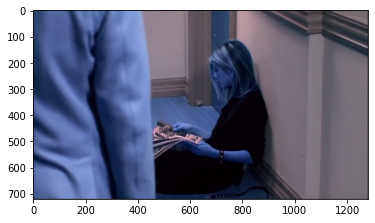

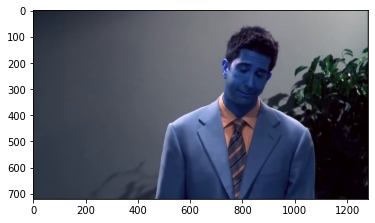

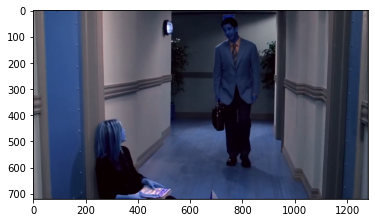

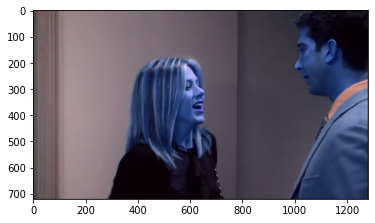

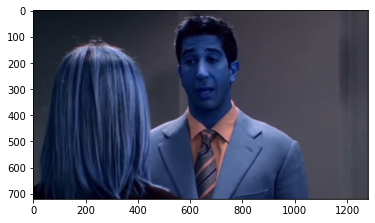

In [27]:
import cv2
import matplotlib.pyplot as plt
# from IPython.display import Image as img

vidcap = cv2.VideoCapture('tst_1.mp4')
success, image = vidcap.read()
count = 1
lim = 5
s_lim = 100
skip = 1
im_arr = []
while success:
  success, image = vidcap.read()
  if skip % s_lim == 0:
    cv2.imwrite("video_data/image_%d.jpg" % count, image)
    # print('Saved image ', count)
    c, p, s = postprocess(list(backend.run_model(model, [preprocess("video_data/image_%d.jpg" % count)])))
    # plt.imshow("Image",image)
    # cv2.waitKey(0)
    # plt.show()
    # img = Image.open("video_data/image_%d.jpg" % count)
    im_arr.append(image)
    print("video_data/image_%d.jpg" % count, rev_dict[c[0]])
    # print(c,p)
    count += 1
    if count > lim:
      break
  skip += 1

for img in im_arr:
    plt.figure()
    plt.imshow(img)